In [1]:
using Gen
using PyPlot
using ProgressBars

┌ Info: Installing pyqt package to avoid buggy tkagg backend.
└ @ PyPlot /Users/kentatakatsu/.julia/packages/PyPlot/4wzW1/src/init.jl:118


### 0. generate synthetic data

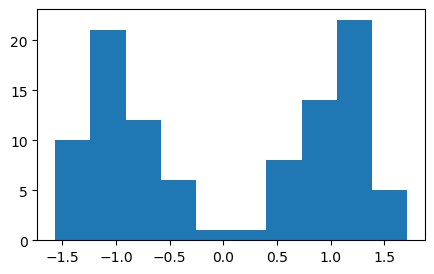

([10.0, 21.0, 12.0, 6.0, 1.0, 1.0, 8.0, 14.0, 22.0, 5.0], [-1.5683599810347877, -1.24003651073576, -0.9117130404367324, -0.5833895701377048, -0.2550660998386771, 0.07325737046035052, 0.40158084075937817, 0.729904311058406, 1.0582277813574335, 1.3865512516564609, 1.7148747219554887], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x156db20f0>, PyObject <matplotlib.patches.Rectangle object at 0x154ca1e48>, PyObject <matplotlib.patches.Rectangle object at 0x156db26a0>, PyObject <matplotlib.patches.Rectangle object at 0x156db29b0>, PyObject <matplotlib.patches.Rectangle object at 0x156db2cc0>, PyObject <matplotlib.patches.Rectangle object at 0x156db2fd0>, PyObject <matplotlib.patches.Rectangle object at 0x156dc3320>, PyObject <matplotlib.patches.Rectangle object at 0x156dc3630>, PyObject <matplotlib.patches.Rectangle object at 0x156dc3940>, PyObject <matplotlib.patches.Rectangle object at 0x156dc3c50>])

In [2]:
# generate gaussian data with mean at -1 and 1
N = 100
mu1, mu2 = -1, 1
sigma1, sigma2 = 0.3, 0.3
X1 = [Gen.normal(mu1, sigma1) for _ in 1:Int(N/2)]
X2 = [Gen.normal(mu2, sigma2) for _ in 1:Int(N/2)]
X = vcat([X1, X2]...)
figure(figsize=(5,3))
hist(X)

### 1 finite mixture model with 2 components

In [3]:
# define generative functions
include("../src/dirichlet.jl")

# map gaussian distribution
@gen function generate_normal(mean::Float64, scale::Float64)
    return @trace(normal(mean, scale), :normal)
end
map_normal = Map(generate_normal)

# multinomiral with dirichlet prior
@gen function DirichletMulti(alpha, K::Int64, N::Int64)
    base = fill(alpha, K)
    pi = dirichlet(base)
    obj = [@trace(categorical(pi), i=>:c) for i in 1:N]
    return obj
end

# gaussian mixture model given list of Int for the component class
@gen function GMM(k, c_label)
    n = length(c_label)
    # mean 
    muVar = @trace(inv_gamma(4.0, 4.0), :muVar)
    mu = @trace(map_normal(fill(0, k), fill(muVar, k)), :mu)
    # generate X
    xNoise = @trace(inv_gamma(4.0, 4.0), :xNoise)
    X = @trace(map_normal(mu[c_label], fill(xNoise, n)), :X)
end

# finite gaussian mixture model with K components
@gen function FGMM(K::Int64, N::Int64)
    alpha = @trace(Gen.gamma(1, 1), :alpha) # prior for the concentration parameter
    class_label = @trace(DirichletMulti(alpha, K, N), :Cluster) # generate cluster labels
    X = @trace(GMM(K, class_label), :Outcome) # generate X given class labels
    return X
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], ##FGMM#374, Bool[0, 0], false)

In [4]:
@gen function invGammaProposal(trace, key, var::Float64)
    cur = trace[key]
    Shape = (cur * cur / var) + 2
    Scale = cur * (Shape - 1)
    return @trace(inv_gamma(Shape, Scale), key)
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Any, Any, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], ##invGammaProposal#375, Bool[0, 0, 0], false)

In [5]:
# sample parameters from posterior distribution
include("../src/inference.jl")
using .Inference


# set observation
obs = Gen.choicemap()
for i in 1:N
    obs[:Outcome=>:X => i => :normal] = X[i]
end

K = 2 # components to model
n_samples = 500 # number of posterior samples
trace, weight = generate(FGMM, (K, N,), obs)
posterior_samples = []
for _ in tqdm(1:n_samples)
    # sample concentration alpha
    trace = alpha_gibbs(trace, K)
    # sample class labels
    trace = class_gibbs(trace, K)
    # sample Mu
    trace = mu_gibbs(trace, K)
    # sample noises (rest relies on Gen's mh)
    (trace, _) = mh(trace, invGammaProposal, (:Outcome=>:xNoise, 0.5, ))
    (trace, _) = mh(trace, invGammaProposal, (:Outcome=>:muVar, 0.5, ))
    
    push!(posterior_samples, get_choices(trace))
end

100.00%┣██████████████████████████████████████████████████████████▉┫ 500/500 00:08<00:00, 61.09 it/s]


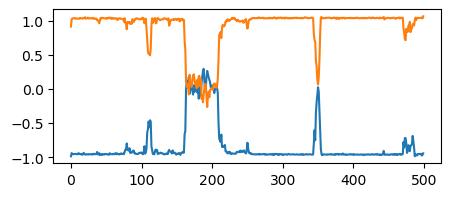

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x156ecc518>

In [6]:
# samples of latent mean (should be near -1 and 1)
figure(figsize=(5,2))
plot([p[:Outcome=>:mu=>1=>:normal] for p in posterior_samples])
plot([p[:Outcome=>:mu=>2=>:normal] for p in posterior_samples])